In [1]:
import sys
import os
import requests
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
#from models.mae import models_mae
from models.mae import models_mae_2
from skimage import draw
import math
import torch.nn.functional as F
import torch.nn as nn

/p/project/hai_dm4eo/wang36/jupyter/kernels/wang36_kernel/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def draw_hog(c_hog):
    c_row, c_col = (8,8)
    orientations = 9
    s_row, s_col = (224,224)
    n_cells_row,n_cells_col = int(s_row // c_row), int(s_col // c_col)
    orientation_histogram = np.transpose(c_hog,(1,2,0))

    radius = min(c_row, c_col) // 2 - 1
    orientations_arr = np.arange(orientations)
    # set dr_arr, dc_arr to correspond to midpoints of orientation bins
    orientation_bin_midpoints = (
        np.pi * (orientations_arr + .5) / orientations)
    dr_arr = radius * np.sin(orientation_bin_midpoints)
    dc_arr = radius * np.cos(orientation_bin_midpoints)
    hog_image = np.zeros((s_row, s_col))
    for r in range(n_cells_row):
        for c in range(n_cells_col):
            for o, dr, dc in zip(orientations_arr, dr_arr, dc_arr):
                centre = tuple([r * c_row + c_row // 2,
                                c * c_col + c_col // 2])
                rr, cc = draw.line(int(centre[0] - dc),
                                   int(centre[1] + dr),
                                   int(centre[0] + dc),
                                   int(centre[1] - dr))
                hog_image[rr, cc] += orientation_histogram[r, c, o]
    #hog_image = (hog_image - hog_image.min()) / (hog_image.max()-hog_image.min())
    return hog_image

In [3]:
def unpatchify(model, x, in_chans):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    p = model.patch_embed.patch_size[0]
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]

    x = x.reshape(shape=(x.shape[0], h, w, p, p, in_chans))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], in_chans, h * p, h * p))
    return imgs

In [47]:
# define the utils

def show_image(id,image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    #plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    image = torch.clip(image * 255, 0, 255).int()
    plt.imshow(image)
    plt.axis('off')
    #plt.savefig('utils/s2_0000004_{}.pdf'.format(title), bbox_inches='tight', format='pdf')
    plt.title(title, fontsize=16)
    
    img = Image.fromarray(image.numpy().astype('uint8'),'RGB')
    img.save('utils/visualize/s2_{:07d}_{}.png'.format(id,title))
    
    return

def prepare_model(chkpt_dir, in_chans=13, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae_2, arch)(in_chans=in_chans,feature='hog',hog_norm=False)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(id,img_s, model):
    x = img_s
    x_d = x

    # run MAE
    #loss, pred, mask, target = model(x.float(),mask_ratio=0.70)
    loss, mask, pred, target, pred2, target2 = model(x.float(),mask_ratio=0.70)
    print(mask.shape,pred.shape,target.shape,pred2.shape,target2.shape) # B,196,468
    #pred = (pred - pred.min()) / (pred.max()-pred.min()+1e-6)
    
    target_1d,_ = model.hog(x)
    mean = target_1d.mean(dim=-1, keepdim=True)
    var = target_1d.var(dim=-1, keepdim=True)
    pred = pred * (var + 1.e-6)**.5 + mean
    
    target2_1d = model.patchify(target2)
    mean2 = target2_1d.mean(dim=-1, keepdim=True)
    var2 = target2_1d.var(dim=-1, keepdim=True)
    #print(mean2.shape,var2.shape,pred2.shape,target2.shape)   
    pred2 = pred2 * (var2 + 1.e-6)**.5 + mean2
    
    pred[mask==0,:] = 0
    bb4 = pred.unflatten(2,(117,2,2)) # 1,196,27,2,2
    bb3 = bb4.unflatten(1,(14,14)) # 1,14,14,27,2,2
    bb2 = bb3.permute(0,1,2,5,3,4).reshape((1,14,28,117,2))
    bb1 = bb2.permute(0,1,4,2,3).reshape((1,28,28,117))
    bb0 = bb1.permute(0,3,1,2) # 1,27,28,28
    bb = bb0.unflatten(1,(13,9)) # 1,3,9,28,28

    #print(torch.quantile(bb,torch.tensor([0.02, 0.98])))
    #print((target-bb).mean())
    
    bb = bb.detach().cpu().numpy()
    y0 = draw_hog(bb[0,3])
    y1 = draw_hog(bb[0,2])
    y2 = draw_hog(bb[0,1])
    y = torch.Tensor(np.stack((y0,y1,y2),-1))
    
    
    
    target = target.detach().cpu().numpy()
    t0 = draw_hog(target[0,3])
    t1 = draw_hog(target[0,2])
    t2 = draw_hog(target[0,1])
    t = torch.Tensor(np.stack((t0,t1,t2),-1))   
    
    # pred2 unpatchify TBD
    pred2 = pred2.detach()
    pred2 = unpatchify(model, pred2, 3)
    pred2 = torch.einsum('nchw->nhwc', pred2).detach().cpu()    
    
    
    
    target2 = target2.detach().cpu().numpy()
    t0 = target2[0,0]
    t1 = target2[0,1]
    t2 = target2[0,2]
    t_2 = torch.Tensor(np.stack((t0,t1,t2),-1))    

    
    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *13)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)
    x_d = torch.einsum('nchw->nhwc', x_d)
    
    
    x = torch.stack((x[:,:,:,3],x[:,:,:,2],x[:,:,:,1]),-1)
    mask = torch.stack((mask[:,:,:,3],mask[:,:,:,2],mask[:,:,:,1]),-1)
    chs = []
    for ch in range(3):
        im = x[:,:,:,ch]
        p1 = torch.quantile(im,0.01)
        p99 = torch.quantile(im,0.99)
        im = torch.clip(im,p1,p99)
        im = (im - p1) / (p99 - p1)
        chs.append(im)
    x = torch.stack(chs,-1)
    #print(x.shape,mask.shape)
    
    #print(y.max(),y.min(),y.mean(),y.median(),t.max(),t.min(),t.mean(),t.median())
    
    chs = []
    for ch in range(3):
        im = y[:,:,ch]
        
        p1 = torch.quantile(im,0.1)
        #p1 = torch.quantile(im,0.25)
        p99 = torch.quantile(im,0.99)
        im = torch.clip(im,p1,p99)
        im = (im - p1) / (p99 - p1)
        #im = im / 1.5
        chs.append(im)
    y = torch.stack(chs,-1)
    
    chs = []
    for ch in range(3):
        im = pred2[0,:,:,ch]
        
        p1 = torch.quantile(im,0.01)
        p99 = torch.quantile(im,0.99)
        im = torch.clip(im,p1,p99)
        im = (im - p1) / (p99 - p1)
        chs.append(im)
    y_2 = torch.stack(chs,-1)    
    
    
    
    chs = []
    for ch in range(3):
        im = t[:,:,ch]
        p1 = torch.quantile(im,0.01)
        p99 = torch.quantile(im,0.99)
        im = torch.clip(im,p1,p99)
        im = (im - p1) / (p99 - p1)
        chs.append(im)
    t = torch.stack(chs,-1)
    
    
    chs = []
    for ch in range(3):
        im = t_2[:,:,ch]
        p1 = torch.quantile(im,0.01)
        p99 = torch.quantile(im,0.99)
        im = torch.clip(im,p1,p99)
        im = (im - p1) / (p99 - p1)
        chs.append(im)
    t_2 = torch.stack(chs,-1)    
    
    
    
    # masked image
    im_masked = x[0] * (1 - mask[0])

    # HOG reconstruction pasted with visible patches
    im_paste = t * (1 - mask[0]) + y * mask[0]
    
    # NDI reconstruction pasted with visible patches
    im_paste_2 = t_2 * (1 - mask[0]) + y_2 * mask[0]    

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 6, 1)
    show_image(id,x[0], "raw")

    plt.subplot(1, 6, 2)
    show_image(id,im_masked, "masked")
    

    plt.subplot(1, 6, 3)
    #show_image(y, "reconstruction")
    show_image(id,im_paste, "reconstruction HOG")

    plt.subplot(1, 6, 4)
    show_image(id,t, "target HOG")  
    
    plt.subplot(1, 6, 5)
    show_image(id,im_paste_2, "reconstruction NDI")
    
    plt.subplot(1, 6, 6)
    show_image(id,t_2, "target NDI")    
    
    #plt.savefig('utils/visualize/s2_{:07d}_all.pdf'.format(id), bbox_inches='tight', format='pdf')

    plt.show()

In [5]:
#chkpt_dir = '/p/project/hai_ssl4eo/wang_yi/MAE-MFP/src/benchmark/pretrain_ssl/checkpoints/mae_vits16_hog_B13/checkpoint-99.pth'
chkpt_dir = '/p/project/hai_ssl4eo/wang_yi/MAE-MFP/src/benchmark/pretrain_ssl/checkpoints/mae_vitl16_hog-indices_B13/checkpoint-99.pth'
model = prepare_model(chkpt_dir, 13, 'mae_vit_large_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


In [6]:
from datasets.SSL4EO.ssl4eo_dataset_lmdb import LMDBDataset,random_subset
from cvtorchvision import cvtransforms

lmdb_file_s2 = '/p/project/hai_dm4eo/wang_yi/data/251k_ms.lmdb'
lmdb_file_s1 = '/p/project/hai_dm4eo/wang_yi/data/251k_sar.lmdb'

transform_train = cvtransforms.Compose([
        #cvtransforms.RandomResizedCrop(224, scale=(0.2, 1.0)),  # 3 is bicubic
        #cvtransforms.RandomHorizontalFlip(),
        #cvtransforms.Resize(224),
        cvtransforms.CenterCrop(224),
        cvtransforms.ToTensor(),
        ])

dataset_train = LMDBDataset(
            lmdb_file=lmdb_file_s2,
            is_slurm_job=False,
            s2c_transform=transform_train,
            mode=['s2c'],
            dtype='uint8',
        )

#dataset_train = random_subset(dataset_train,frac=1,seed=42)
#dataloader = torch.utils.data.DataLoader(dataset_train,shuffle=False,batch_size=1)

torch.Size([1, 196]) torch.Size([1, 196, 468]) torch.Size([1, 13, 9, 28, 28]) torch.Size([1, 196, 768]) torch.Size([1, 3, 224, 224])


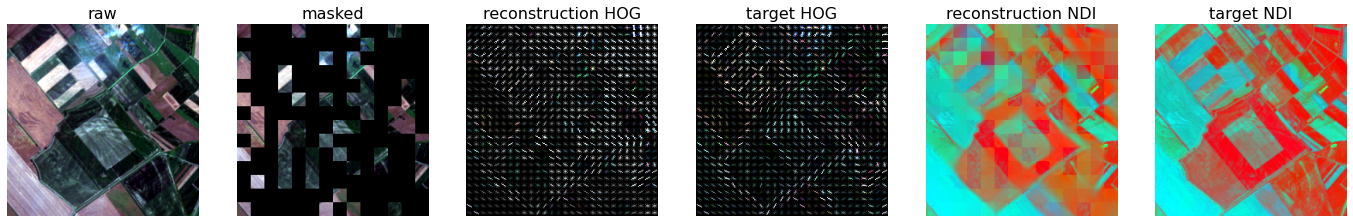

In [63]:
id = 13
img_in = dataset_train[id].unsqueeze(0)
run_one_image(id,img_in, model)